In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
usage_df = pd.read_csv('preprocessed_model_data.csv')

In [3]:
usage_df.head()

,ZipCode,County,Month,Year,CustomerClass,TotalkWh,TotalGWh,Date
0,90001,Los Angeles County,1,2015,Residential,3872318.0,3.872318,2015-01-01
1,90001,Los Angeles County,1,2015,Commercial,4278310.0,4.278310,2015-01-01
2,90002,Los Angeles County,1,2015,Residential,1440786.0,1.440786,2015-01-01
3,90002,Los Angeles County,1,2015,Commercial,505206.0,0.505206,2015-01-01
4,90008,Los Angeles County,1,2015,Residential,439343.0,0.439343,2015-01-01


In [4]:
usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127151 entries, 0 to 127150
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ZipCode        127151 non-null  int64  
 1   County         127151 non-null  object 
 2   Month          127151 non-null  int64  
 3   Year           127151 non-null  int64  
 4   CustomerClass  127151 non-null  object 
 5   TotalkWh       127151 non-null  float64
 6   TotalGWh       127151 non-null  float64
 7   Date           127151 non-null  object 
dtypes: float64(2), int64(3), object(3)
memory usage: 7.8+ MB


In [5]:
# Creating GWh field from converting kWh
usage_df['TotalGWh'] = usage_df['TotalkWh'] / 1000000

In [6]:
# Creating 'Date' column to combine Month and Year
usage_df['Date'] = usage_df['Month'].astype(str) + '-' + usage_df['Year'].astype(str)

In [7]:
usage_df['Date'] = pd.to_datetime(usage_df['Date'], format='%m-%Y')

In [8]:
usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127151 entries, 0 to 127150
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   ZipCode        127151 non-null  int64         
 1   County         127151 non-null  object        
 2   Month          127151 non-null  int64         
 3   Year           127151 non-null  int64         
 4   CustomerClass  127151 non-null  object        
 5   TotalkWh       127151 non-null  float64       
 6   TotalGWh       127151 non-null  float64       
 7   Date           127151 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 7.8+ MB


In [9]:
# Setting 'Date' as the index
usage_df = usage_df.set_index('Date')

In [10]:
usage_df.head()

,ZipCode,County,Month,Year,CustomerClass,TotalkWh,TotalGWh
Date,,,,,,,
2015-01-01,90001,Los Angeles County,1,2015,Residential,3872318.0,3.872318
2015-01-01,90001,Los Angeles County,1,2015,Commercial,4278310.0,4.278310
2015-01-01,90002,Los Angeles County,1,2015,Residential,1440786.0,1.440786
2015-01-01,90002,Los Angeles County,1,2015,Commercial,505206.0,0.505206
2015-01-01,90008,Los Angeles County,1,2015,Residential,439343.0,0.439343


## Resampling dataframe to total monthly usage

In [11]:
usage = usage_df[['TotalkWh','TotalGWh']].resample('M').sum()

In [12]:
usage.head()

,TotalkWh,TotalGWh
Date,,
2015-01-31,6.599934e+09,6599.933897
2015-02-28,6.259748e+09,6259.747929
2015-03-31,5.749336e+09,5749.335961
2015-04-30,6.496674e+09,6496.673947
2015-05-31,6.478335e+09,6478.335350


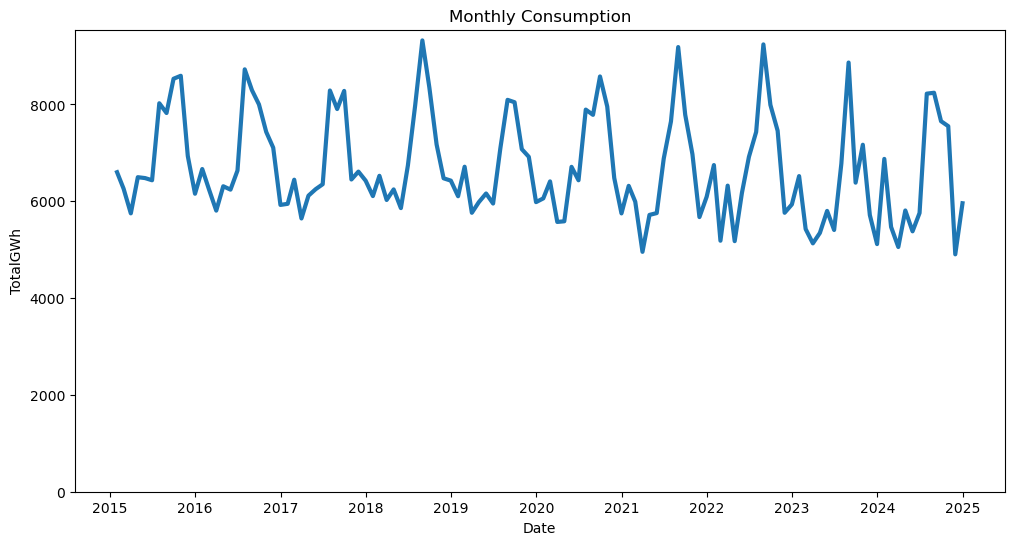

In [13]:
# PLotting data
plt.figure(figsize=(12, 6))
plt.plot(usage['TotalGWh'], linewidth=3)
plt.title("Monthly Consumption")
plt.xlabel("Date")
plt.ylabel("TotalGWh")
plt.ylim(ymin=0)
plt.show()

## Implementing SARIMAX model

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [15]:
# Checking for stationarity of data

def check_stationarity(timeseries):
    # Perform the Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    print('Stationary' if p_value < 0.05 else 'Non-Stationary')
 
 
check_stationarity(usage['TotalGWh'])

ADF Statistic: -1.1219915544260948
p-value: 0.706222730570806
Non-Stationary


***SARIMAX model can still handle non-stationary data***

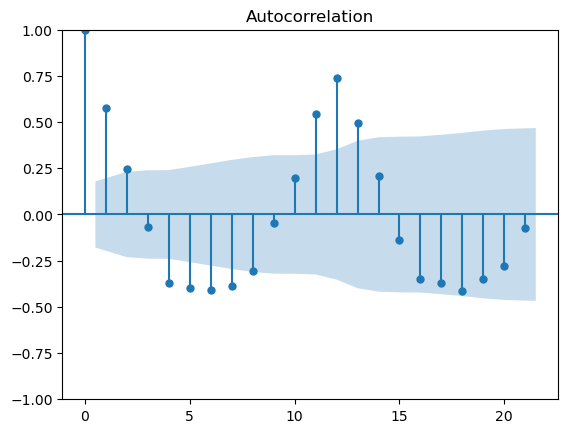

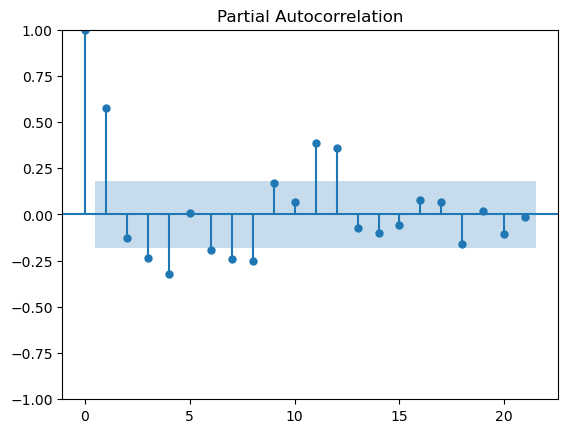

In [16]:
 # Plot ACF and PACF
plot_acf(usage['TotalGWh'])
plot_pacf(usage['TotalGWh'])
plt.show()

## Using AutoArima to find the parameters for SARIMAX model

In [17]:
# Install the library if necessary
# !pip install pmdarima

# Import the library
from pmdarima.arima import auto_arima

# Build and fit the AutoARIMA model
model = auto_arima(usage['TotalGWh'],
                   test='adf',
                   seasonal=True,
                   #max_p=3, max_q=3,
                   start_p=0,
                   d=1,
                   trace=True,
                   start_P=0,
                   m=12,
                   #D=None,
                   stepwise=True,
                   with_intercept=True,
                   suppress_warnings=True)

model.fit(usage['TotalGWh'])

# Check the model summary
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1975.403, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1910.186, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1938.298, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1973.411, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1975.629, Time=0.01 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=1907.284, Time=0.27 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=1902.025, Time=0.86 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=1902.357, Time=0.26 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=1902.116, Time=0.91 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=1933.176, Time=1.00 sec
 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=1892.014, Time=1.18 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=1888.768, Time=0.75 sec
 ARIMA(2,1,0)(0,0,1)[12] inte

In [18]:
# p, d, q parameters
model.order

(2, 1, 0)

In [19]:
# P, D, Q, s parameters
model.seasonal_order

(1, 0, 1, 12)

In [20]:
# Define SARIMA parameters from AutoArima results
 
# Fit the SARIMA model
model = SARIMAX(usage['TotalGWh'], order=model.order, seasonal_order=model.seasonal_order)
results = model.fit()
model

In [21]:
# Calculate the mean absolute error from residuals

mae = np.mean(np.abs(results.resid))

# Print mean absolute error

print('MAE: %.3f' % mae)

MAE: 559.430


### Forecasting the next 12 months

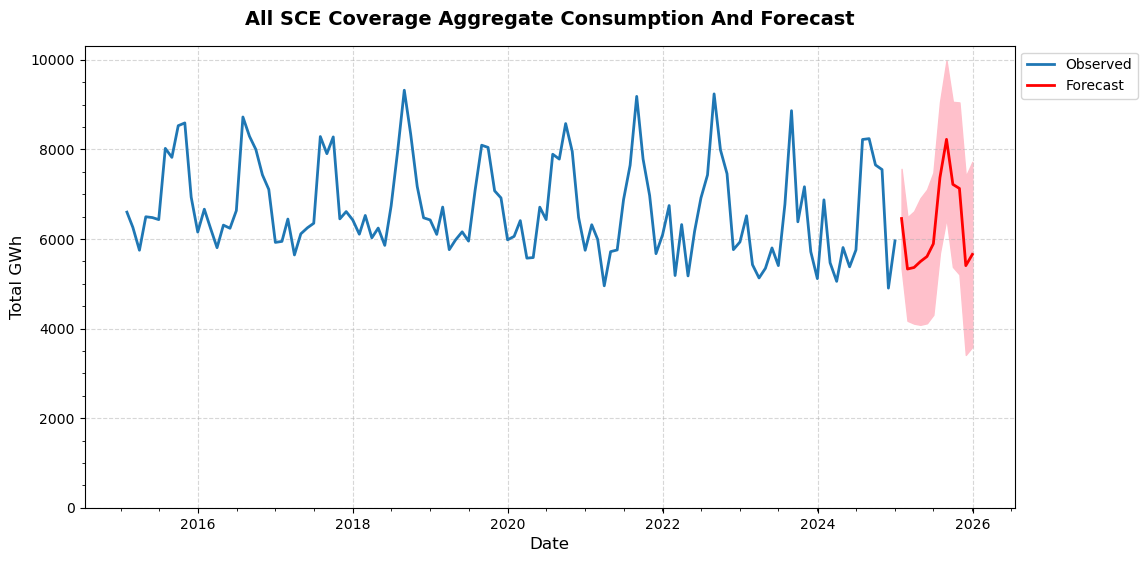

In [22]:
from matplotlib.ticker import AutoMinorLocator

# Forecast future demand
forecast_periods = 12  # Forecast the next 12 months
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot settings
plt.figure(figsize=(12, 6))
ax1 = sns.lineplot(data=usage['TotalGWh'], label='Observed',linewidth=2)
ax2 = sns.lineplot(data=forecast_mean, label='Forecast', color='red', linewidth=2)

# Fill between forecast confidence intervals
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')


# Plot labels and legend
plt.title("All SCE Coverage Aggregate Consumption And Forecast", weight='bold', fontsize=14,pad=15)
plt.xlabel("Date",fontsize=12)
plt.ylabel("Total GWh",fontsize=12)
plt.ylim(bottom=0)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.14, 1), loc='upper right')

# Show plot
#plt.savefig('all_sce_forecast.png')
plt.show()

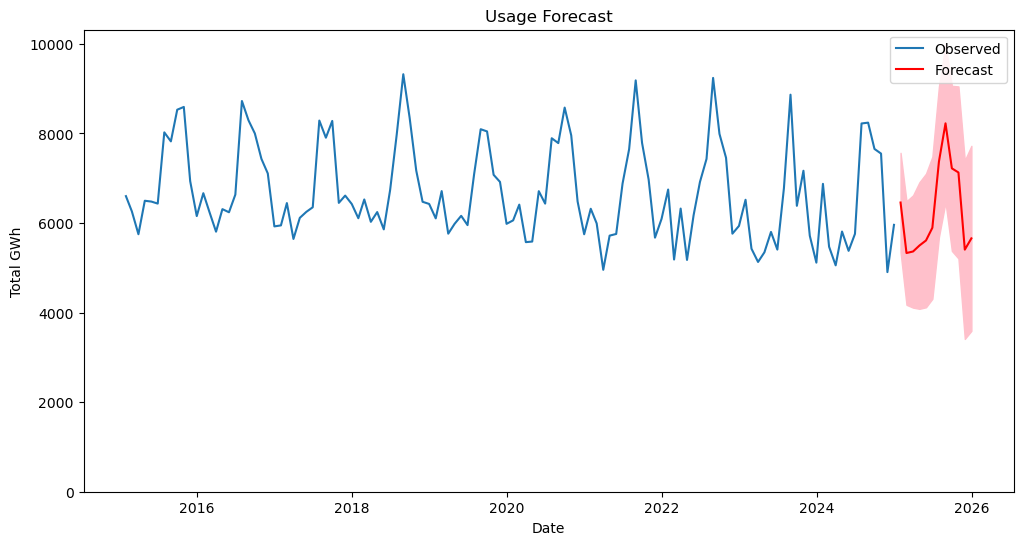

In [23]:
# Forecast future demand
#forecast_periods = 12  # Forecast the next 12 months
#forecast = results.get_forecast(steps=forecast_periods)
#forecast_mean = forecast.predicted_mean
#forecast_ci = forecast.conf_int()
 
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(usage['TotalGWh'], label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Usage Forecast")
plt.xlabel("Date")
plt.ylabel("Total GWh")
plt.ylim(ymin=0)
plt.legend()
plt.show()

### Evaluate Model

In [24]:
observed = usage['TotalGWh'][-forecast_periods:]
mae = mean_absolute_error(observed, forecast_mean)
mse = mean_squared_error(observed, forecast_mean)
rmse = np.sqrt(mse)
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MAE: 339.3901286810183
MSE: 157824.38329843854
RMSE: 397.2711709883295


In [25]:
observed

Date
2024-01-31    6874.243089
2024-02-29    5469.841570
2024-03-31    5054.460759
2024-04-30    5809.234366
2024-05-31    5378.588026
2024-06-30    5757.200322
2024-07-31    8222.266194
2024-08-31    8240.649850
2024-09-30    7653.551659
2024-10-31    7550.048888
2024-11-30    4903.567180
2024-12-31    5958.640238
Freq: M, Name: TotalGWh, dtype: float64

In [27]:
forecast_mean

2025-01-31    6457.383702
2025-02-28    5329.869287
2025-03-31    5363.990730
2025-04-30    5497.063051
2025-05-31    5609.905760
2025-06-30    5893.612866
2025-07-31    7370.051497
2025-08-31    8225.195301
2025-09-30    7219.983617
2025-10-31    7128.424308
2025-11-30    5405.454985
2025-12-31    5656.971601
Freq: M, Name: predicted_mean, dtype: float64

## Consumption By Customer Class

In [28]:
customer_consum = usage_df.groupby('CustomerClass')['TotalGWh'].sum()
customer_consum

CustomerClass
Agricultural     31909.568638
Commercial      270301.826869
Industrial      211935.764070
Residential     288144.634869
Name: TotalGWh, dtype: float64

In [29]:
customer_df = customer_consum.reset_index()
customer_df

,CustomerClass,TotalGWh
0,Agricultural,31909.568638
1,Commercial,270301.826869
2,Industrial,211935.764070
3,Residential,288144.634869


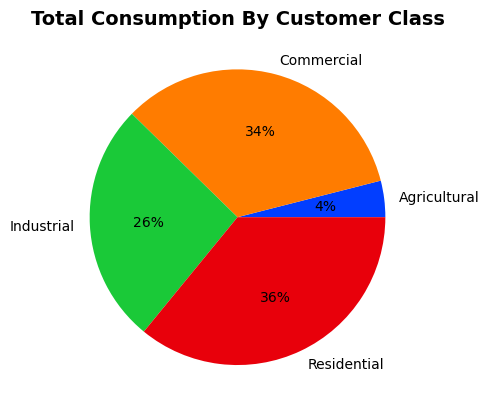

In [30]:
# With Percentages

# Plotting Total GWh usage per customer type
palette_color = sns.color_palette("bright") 
plt.pie(customer_df['TotalGWh'], labels=customer_df['CustomerClass']
       ,colors=palette_color, autopct='%.0f%%', textprops=dict(color='black'))
plt.title('Total Consumption By Customer Class', fontsize=14, weight='bold', loc='Center')
#plt.legend(customer_df['CustomerClass'], loc='upper right',bbox_to_anchor=(0.9,0,0.5, 1))
plt.show()

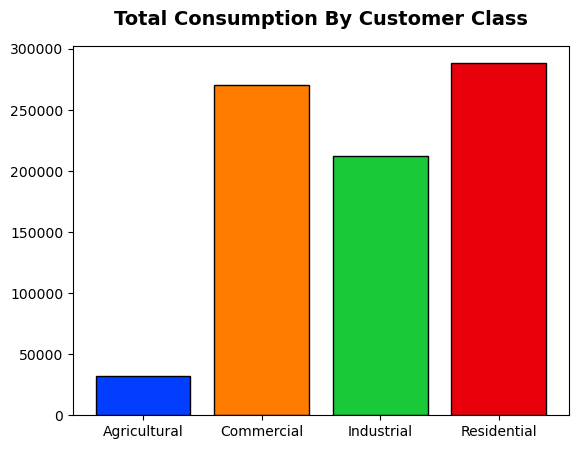

In [31]:
# Bar chart
plt.bar(customer_df['CustomerClass'],customer_df['TotalGWh'], color=palette_color,edgecolor='black', )
plt.title('Total Consumption By Customer Class', fontsize=14, weight='bold', loc='Center', pad=15)
plt.show()

### Using Jupyter Magic Store (%store)

#### Storing p,d,q parameters so they can be retrieved and used in time_decomposition_2 model for STL Forecast

*Already executed it once so no need to re-run it because it's already stored.*

In [32]:
#arima_inputs = model.order

In [33]:
#%store arima_inputs